Análisis de performance de agentes - Búsqueda Local
===
# Tiempo de ejecución

In [1]:
import NQueens
import random
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from time import time_ns

## Se llevará a cabo con la siguiente configuración:

In [2]:
algorithms = [NQueens.hill_climbing, NQueens.simulated_annealing, NQueens.genetic_algorithm]
sizes = [4, 8, 10, 12, 15]
n_iterations = 30
iter_limit_pow = 4
random.seed(42)

---

# Tiempo de ejecución

## Correr simulación

In [3]:
def run_simulation(simulations, algorithms, size, limit):
    # Run in each agent
    for algorithm in algorithms:
        # Run agent
        start = time_ns()
        _, best_h, iterations, _ = algorithm(size, limit)
        end = time_ns()
        
        # Append results in the siumlations dict
        simulations.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'best_h': best_h,
            'iterations': iterations,
            'time_ms': (end-start)/1e6
        })

In [4]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for size in sizes:
        for _ in range(n_iterations):
            pool.apply_async(run_simulation, args=(simulations, algorithms, size, size**iter_limit_pow))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_df = pd.DataFrame(list(simulations))

simulations_df.to_csv('simulations.csv')
simulations_df

,algorithm,size,best_h,iterations,time_ms
0,hill_climbing,4,2,12,0.145181
1,hill_climbing,4,0,36,0.272992
2,hill_climbing,4,1,12,0.137141
3,hill_climbing,4,1,12,0.120200
4,hill_climbing,4,2,12,0.156880
...,...,...,...,...,...
445,genetic_algorithm,15,3,51000,2237.940685
446,genetic_algorithm,15,3,51000,2489.388735
447,genetic_algorithm,15,3,51000,2292.612192
448,genetic_algorithm,15,4,51000,2368.323283


## Análisis del performance de cada algorítmo

In [5]:
samples_list = []

for algorithm in algorithms:
    for size in sizes:
        sample_df = simulations_df.query(f'algorithm == "{algorithm.__name__}" and size == {size}')
        
        # Find optimals
        try:
            optimals = sample_df.best_h.value_counts().loc[0]
        except KeyError:
            optimals = 0
        
        # Save saple report
        samples_list.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'optimal_rate': optimals / n_iterations,
            'time_ms_avg': sample_df['time_ms'].mean(),
            'time_ms_std': sample_df['time_ms'].std(),
            'iter_avg': sample_df['iterations'].mean(),
            'iter_std': sample_df['iterations'].std()
        })

# Print table
samples_df = pd.DataFrame(samples_list)
samples_df.to_csv('samples.csv')
samples_df

,algorithm,size,optimal_rate,time_ms_avg,time_ms_std,iter_avg,iter_std
0,hill_climbing,4,0.200000,0.181003,0.205204,19.600000,13.548381
1,hill_climbing,8,0.066667,1.598756,0.825093,218.400000,112.337423
2,hill_climbing,10,0.033333,2.886141,1.237166,366.000000,160.185238
3,hill_climbing,12,0.000000,6.119728,3.450527,721.600000,414.145202
4,hill_climbing,15,0.000000,13.470601,4.715765,1428.000000,491.411759
5,simulated_annealing,4,1.000000,1.284764,1.059776,121.066667,75.432058
6,simulated_annealing,8,0.900000,11.522931,11.667551,1142.566667,1171.250045
7,simulated_annealing,10,1.000000,21.059199,20.113264,1985.500000,1937.774172
8,simulated_annealing,12,1.000000,30.326389,31.315462,2714.833333,2789.884376
9,simulated_annealing,15,1.000000,39.899019,26.207611,3208.900000,2186.807299


## Gráficos
### Box plot - Tiempo empleado hasta llegar a una solución

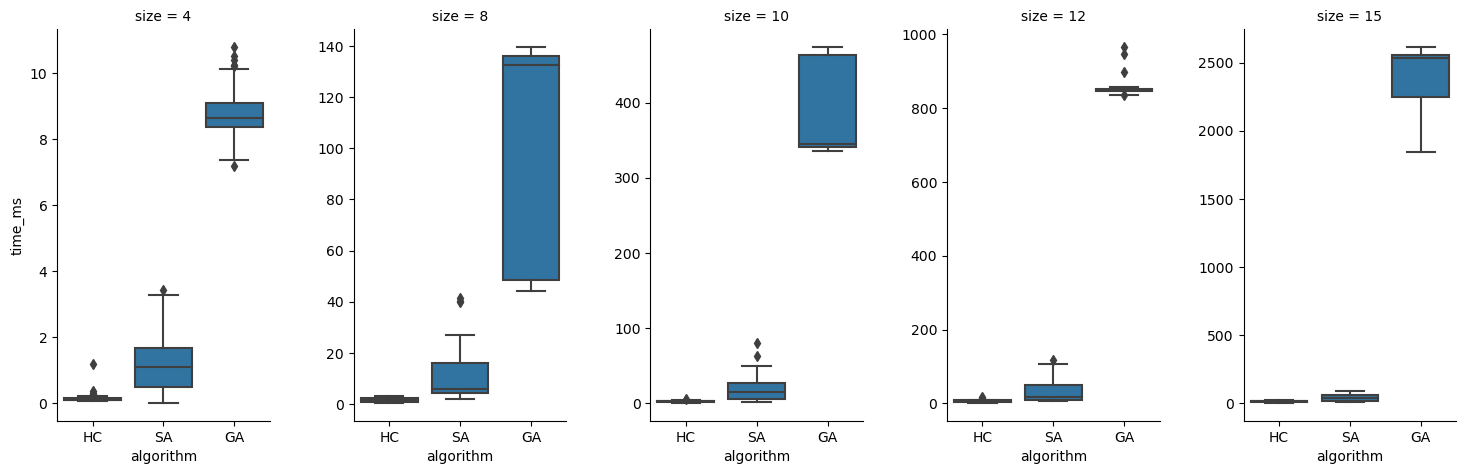

In [6]:
%matplotlib inline

grid1 = sns.FacetGrid(data=simulations_df, col='size', sharey=False)
grid1.map(sns.boxplot, 'algorithm', 'time_ms', order= [x.__name__ for x in algorithms])
grid1.set_xticklabels(['HC', 'SA', 'GA'])

grid1.fig.subplots_adjust(top=1.5)
grid1.savefig('time_by_algorithm.svg')


# Comportamiento de h()

## Se llevará acabo con la siguiente configuración

In [15]:
size = 24
n_iterations = 3
limit = 5000

In [16]:
def run_simulation_h(simulations, algorithms, size, limit, i):
    for algorithm in algorithms:
        # Run agent
        _, _, _, h_history = algorithm(size, limit)

        # Dump the data to the simulations list
        for step, h in h_history:
            simulations.append({
                'algorithm': algorithm.__name__,
                'iter': i,
                'step': step,
                'h': h
            })

In [17]:
with mp.Manager() as manager:
    simulations_h = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Run
    for i in range(n_iterations):
        pool.apply_async(run_simulation_h, args=(simulations_h, algorithms, size, limit, i))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a list
    simulations_h_df = pd.DataFrame(list(simulations_h))

### Lineplot - Comportamiento de h() por algorítmo, en tableros idénticos

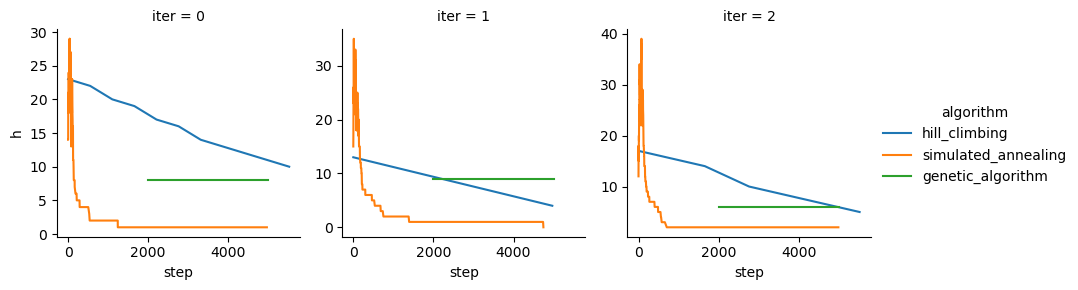

In [18]:
%matplotlib inline

grid2 = sns.FacetGrid(data=simulations_h_df, hue='algorithm', col='iter', sharey=False)
grid2.map(sns.lineplot, 'step', 'h')
grid2.add_legend()

grid1.savefig('h-behavior.svg')